# Deep Learning with Images Bootcamp Session 3

In the second half of the session, we will explore three key computer vision problems:

  - **Image Classification** (LeNet)
  - **Segmentation** (U-Net)
  - **Diffusion Models** (DDPM)

# Image Classification

**Overall Pipeline:**

1. Data Collection and Annotation
2. Data Pre-processing
3. Model Development
4. Model Training
5. Fine-tuning
6. Evaluation on Test Set


## 1. Installation and Imports

In [ ]:
# ---- Import ----
import os, random, math, time
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# ---- Reproducibility ----
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Downloading the dataset from Kaggle

In [ ]:
import os, json

os.makedirs("/root/.kaggle", exist_ok=True)

kaggle_json = {
    "username": "Sankeerthana03",
    "key": "KGAT_f31deeeaecd714f2bfd3b656e5237ffe"
}

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)


In [ ]:
!kaggle datasets list | head

ref                                                             title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                             Chocolate Sales                                      468320  2026-01-04 14:23:35.490000          13287        230  1.0              
emirhanakku/synthetic-healthcare-patient-journey-dataset        Synthetic Healthcare Patient Journey Dataset          38540  2026-02-02 21:18:38.177000            656         27  1.0              
aliiihussain/amazon-sales-dataset                               Amazon_Sales_Dataset                                1297759  2026-02-01 11:37:12.353000           1488         38  1.0              
ayeshaimran1619

In [ ]:
!kaggle datasets download -d youssifhisham/colored-mnist-dataset
!unzip colored-mnist-dataset.zip -d colorized_mnist


Streaming output truncated to the last 5000 lines.
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5410.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5513.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5590.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5613.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5636.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5735.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5755.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5813.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5880.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5899.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5944.png  
  inflating: colorized_mnist/colorized-MNIST-master/training/4/blue_5969.png  
 

## 2. Loading the Dataset

In [ ]:
DATA_DIR = r"/content/colorized_mnist/colorized-MNIST-master"  # change this
TRAIN_DIR = os.path.join(DATA_DIR, "training")
TEST_DIR  = os.path.join(DATA_DIR, "testing")

# LeNet expects small inputs; we'll resize to 32x32 (classic LeNet setting)
mean = (0.5, 0.5, 0.5)
std  = (0.5, 0.5, 0.5)

# NOTE: TO ensure that the analysis of the model's performance is fair, we keep the transforms and augmentations the same for
# both training and testing sets.

train_tfms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),  #To-DO
])

test_tfms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),  # To-Do
])

# Scans the data directory for class-named subfolders and pairs the images with their labels and applies the transforms
full_train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
test_ds = datasets.ImageFolder(TEST_DIR,  transform=test_tfms)
# output - (image, label)

# Extracting the class_names out to allow easier analysis
class_names = full_train_ds.classes
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

### Displaying the Images

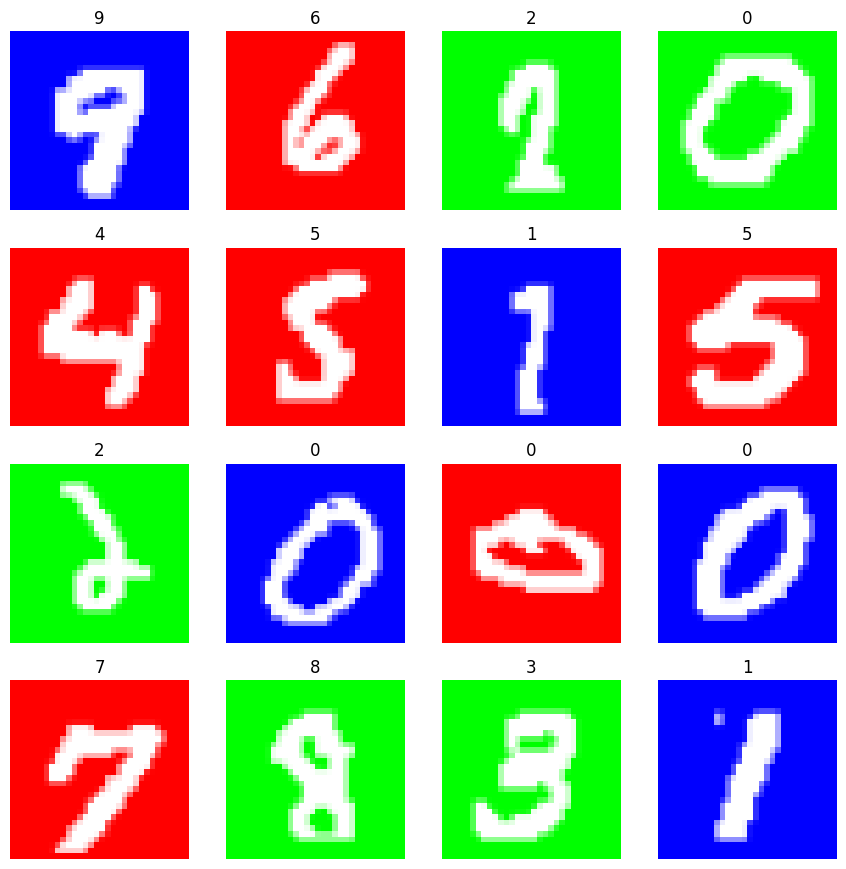

In [ ]:
def show_batch(ds, n=16):
    idxs = np.random.choice(len(ds), n, replace=False)
    imgs, labels = zip(*[ds[i] for i in idxs])

    # unnormalize for display
    imgs = torch.stack(imgs)
    imgs = imgs * torch.tensor(std).view(1,3,1,1) + torch.tensor(mean).view(1,3,1,1)
    imgs = imgs.clamp(0,1)

    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i].permute(1,2,0))
        plt.title(str(labels[i]))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(full_train_ds, n=16)

###  Splitting the Dataset

General Practise is to split the dataset into 3 splits - Training, Validation and Test. What is usually given in the dataset is a training and a test set, where training set contains the image-label pairs that the model learns from, and the test set is a subset of the dataset that the model has never seen. The performance of the model is analysed on how it performs on the test set (unseen data) to replicate real-world scenarios. However, it is highly encouraged (almost all the time) to have an intermediary 'validation' set to act as a 'pseudo test set' during the training process, so the model gets feedback (self-check) on how it's learning process and rectifies its learning.

- Training Set - what the model sees and learns from
- Validation Set - pseudo-test set for the model to use as its playing ground to rectify it's learning during training
- Test Set - unseen data for the model

NOTE: The integrity of the experiment/model's learning is compromised is ther eis any form of data leakage across these sets.

The whole dataset is usually divided into a ratio of 80-10-10 or 70-20-10 (Training-Validation-Test) sets. Hpowever, in this case, the dataset in kaggle is already split, we'll go with the given split.


In [ ]:
total_train = int(len(full_train_ds))
total_test = int(len(test_ds))

print(f"Total number of images in the full training set: {total_train}")
print(f"Total number of images in the test set: {total_test}")

Total number of images in the full training set: 8835
Total number of images in the test set: 10000


In this case, to get the validation split, we split the existing training set - (15% of the existing training set) to get the validation set.

In [ ]:
# Creating a configuration class called CFG and creating an instance of it
@dataclass
class CFG:
    batch_size: int = 128
    num_workers: int = 2
    val_frac: float = 0.15

cfg = CFG()

# Calculating the number of images of the validation set
val_size = int(len(full_train_ds) * cfg.val_frac)
train_size = len(full_train_ds) - val_size

# Splitting the training set to get the vaidation set
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size],
                                generator=torch.Generator().manual_seed(42))

#### DataLoader

Dataloader is what feeds the data into the model batch by batch in the right order. It is responsible for arranging data into batches, shuffling and loading data efficiently during training.

We usually cannot load the entire dataset into the model at once. Instead, we train using mini-batches, and the DataLoader automates this process.

### ✅ Student Task: Data Loaders

Using train_loader as an example, code the data loader for test and val as well.

**NOTE:** Do **NOT** shuffle the data for validation and test sets.

** Question to Think about:**
- Why do we not shuffle the validation and test sets?

  - Because these sets are used to evaluate, not learn, and maintaining their original order (or structure) is crucial for accurate, consistent, and realistic performance metrics.


In [ ]:
# creating the daa loaders
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

print(f"Total Number of images in each set after the split:")
print(f"---------------------------------------------------------")
print(f"Training Set: {len(train_ds)}")
print(f"Validation Set: {len(val_ds)}")
print(f"Test Set: {len(test_ds)}")

Total Number of images in each set after the split:
---------------------------------------------------------
Training Set: 7510
Validation Set: 1325
Test Set: 10000


### Model Building

Building LeNet from scratch

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),  # 32->28
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),                # 28->14

            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), # 14->10
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),                # 10->5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                 # 16*5*5 = 400
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = LeNet(num_classes=10).to(device)
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

Total number of parameters: 62006


#### Minibatches


**What is a Mini-Batch?**

Assume we have **10 images** in our dataset:

> Images = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

We choose a **batch size = 4**

The dataset is grouped into small chunks (mini-batches):

> Mini-batch 1 = {1, 2, 3, 4}

> Mini-batch 2 = {5, 6, 7, 8}

> Mini-batch 3 = {9, 10}


- Each mini-batch is processed **one at a time**
- Each mini-batch produces **one model update**


**How Many Mini-Batches Are There in One Epoch?**

We use simple division, so:

Total samples = 10
Batch size = 4

Number of mini-batches = \frac{10}{4} = 2.5

Since we cannot have half a mini-batch, we round up, giving:

Number of mini-batches = 3

So:

1 epoch = 3 mini-batches

> **1 epoch = 3 mini-batches**

**What the Model Actually Sees**

Instead of learning from one image at a time, the model learns from a group of images. This makes training:
- Faster
- More stable
- Memory-efficient


**What Happens When We Shuffle the Data?**

Before forming mini-batches, the data order is randomly shuffled.

> Original order: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

> Shuffled order: {6, 2, 9, 1, 8, 3, 10, 4, 7, 5}

Mini-batches are then created from the shuffled data:

> Mini-batch 1 = {6, 2, 9, 1}

> Mini-batch 2 = {8, 3, 10, 4}

> Mini-batch 3 = {7, 5}

Shuffling helps the model generalize better and prevents it from learning patterns based on data order.

**Key Takeaway:**
A mini-batch is simply a small group of samples that the model learns from at one time, instead of using the entire dataset at once.

**How This Looks in PyTorch:**

```python
for images, labels in train_loader:
    print(images.shape)




## Training the Model

### Training Loop and Storing Metrics

In [ ]:
def accuracy_from_logits(logits, y):
    """
    Function that returns the model's prediction - class index with the highest score
    """
    preds = logits.argmax(dim=1)  #argmax picks the class index with the highest score for each image

    # preds==y --> gives [True, False...True] - a boolean array
    # Converting it into float() --> gives [1,0,...1] and then taking mean of it
    return (preds == y).float().mean().item()


def train_one_epoch(model, loader, criterion, optimizer):
    """
    This functions entails the computations happening in one training epoch
    which includes, generating the logits -> calculating the loss ->
    backpropagation -> updating parameters
    """
    # puts the model in training mode
    model.train()
    running_loss, running_acc = 0.0, 0.0 # initializing loss and accuracy

    for x, y in loader:
        x, y = x.to(device), y.to(device). #moving x,y to gpu/cpu so that computations happen on the same device

        # Clearing old gradients. Pytorch accumulates gradient by default, so
        # if you dont clear them, gradients become incorrect.
        optimizer.zero_grad(set_to_none=True)

        # Forward pass: model produces raw class scores
        logits = model(x)

        # computes how wrong the model is
        loss = criterion(logits, y)

        # Backpropagation
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Update the loss and accuracy across batches and return the average
        running_loss += loss.item()
        running_acc  += accuracy_from_logits(logits, y)

    return running_loss / len(loader), running_acc / len(loader)

@torch.no_grad(). # --> disables gradient tracking
def eval_one_epoch(model, loader, criterion):
    """
    Function to code for validation in one epoch.
    """
    # puts the model in evaluating mode
    model.eval()
    running_loss, running_acc = 0.0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # getting the logits
        logits = model(x)

        # computing how wrong the model is
        loss = criterion(logits, y)

        # updating loss and accuracy
        running_loss += loss.item()
        running_acc  += accuracy_from_logits(logits, y)

    return running_loss / len(loader), running_acc / len(loader)

def fit(model, train_loader, val_loader, lr=1e-3, weight_decay=0.0, epochs=10):
    # Loss Instantiation
    criterion = nn.CrossEntropyLoss()

    # Instantiating the optimizer with the parameters
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Dictionary to keep track of Training progress - useful for analysis later
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}


    best_val_acc = -1
    best_state = None

    for epoch in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = eval_one_epoch(model, val_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        # This saves the model weights when validation accuracy improves
        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        dt = time.time() - t0
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f} | {dt:.1f}s")

    return history, best_state

In image classification, our model takes an image x and outputs logits — a score for each class.

Training means:
- Forward pass: logits = model(x)

- Compute loss: compare logits vs true label y.

- Backpropagation: compute gradients

- Update weights: optimizer steps in the direction that reduces loss
Repeat for many batches and many epochs

We also run a validation loop to check generalization (no learning, just evaluation).

### Training the Model

We start the training process of the model and monitor it.

In [ ]:
set_seed(42)
model = LeNet(num_classes=10).to(device)

history, best_state = fit(
    model, train_loader, val_loader,
    lr=1e-3, weight_decay=0.0, epochs=10
)

Epoch 01/10 | train loss 1.3396 acc 0.5777 | val loss 0.6189 acc 0.7982 | 3.7s
Epoch 02/10 | train loss 0.4702 acc 0.8577 | val loss 0.4005 acc 0.8812 | 4.4s
Epoch 03/10 | train loss 0.3539 acc 0.8921 | val loss 0.3483 acc 0.8896 | 3.4s
Epoch 04/10 | train loss 0.2876 acc 0.9113 | val loss 0.2936 acc 0.9125 | 3.4s
Epoch 05/10 | train loss 0.2387 acc 0.9274 | val loss 0.2319 acc 0.9329 | 3.5s
Epoch 06/10 | train loss 0.1914 acc 0.9433 | val loss 0.2030 acc 0.9436 | 4.4s
Epoch 07/10 | train loss 0.1664 acc 0.9503 | val loss 0.1745 acc 0.9442 | 4.4s
Epoch 08/10 | train loss 0.1440 acc 0.9560 | val loss 0.1617 acc 0.9492 | 3.4s
Epoch 09/10 | train loss 0.1301 acc 0.9625 | val loss 0.1572 acc 0.9536 | 4.5s
Epoch 10/10 | train loss 0.1079 acc 0.9672 | val loss 0.1461 acc 0.9584 | 3.7s


## Performance Analysis

We analyse the training and validation loss and accuracy cruves.

### Plotting the Loss and Accuracy Curves

### ✅ Student Task: Interpreting Curves
Overfitting: train improves but val plateaus/worsens (gap grows).

Underfitting: both stay poor.

**Write 2 lines about the curves plotted below.**


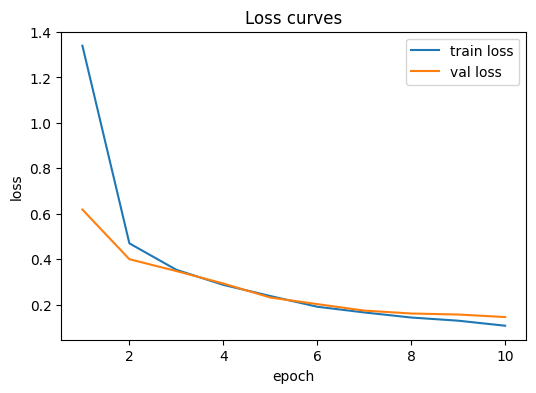

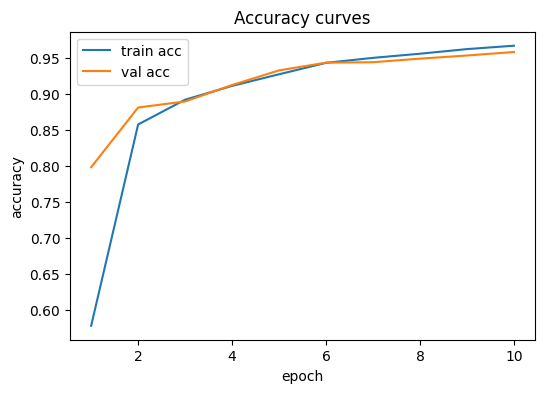

In [ ]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"])+1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss curves")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy curves")
    plt.show()

plot_history(history)

**What is “loss”?**
- Loss measures how wrong the model’s predictions are.
Lower loss means the model’s predictions are closer to the true labels.

**What we observe:**
- Training loss decreases rapidly at the beginning
  - The model is quickly learning basic patterns in the images.
- Validation loss also decreases steadily
  - The model is learning patterns that generalize to unseen data.
- Both curves remain close to each other
  - This is a strong sign that the model is not overfitting.

**Key takeaway:**
When training and validation loss decrease together and stay close, the model is learning useful features rather than memorizing the training data.

**What is “accuracy”?**
- Accuracy measures how often the model predicts the correct class.

**What we observe:**
- Training accuracy increases quickly
  - The model is learning to classify the training images correctly.
- Validation accuracy closely follows training accuracy
  - The learned features generalize well to unseen images.
- Both curves plateau near the end
  - The model has reached a point of diminishing returns, where more training yields only small improvements.

**Key takeaway:**
When validation accuracy closely tracks training accuracy, it indicates good generalization and stable learning.

**NOTE:** In general, Overfitting happens when the model keeps improving on training data but gets worse on validation data — the curves move in opposite directions, which is NOT happening here!

In [ ]:
# reverting to the model's best performance for evaluation purposes
# load best on val
model.load_state_dict(best_state)

<All keys matched successfully>

### Testing the Model on Unseen Data

### ✅ Student Task: Understanding Importance of Unseen Data

**Question to think:**
 - Why is it important to evaluate the model on unseen data?
    - To evaluate its ability to generalize to real-world scenarios, ensuring it has learned underlying patterns rather than simply memorizing training data. It identifies overfitting (low training error, high test error), prevents data leakage, and validates performance reliability, which is essential for accuracy and ethical AI.

In [ ]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Test Loss: 0.14852337110080296
Test Accuracy: 0.9532238924050633


This is in line with the loss and accuracy curves shown above.

## Fine-Tuning the Model

Keeping the model architecture fixed, but carefully adjusting the training hyperparameters so the model learns better, faster, and more stably.

### Random Search

Random search is a hyperparameter optimization technique that randomly selects and tests combinations of hyperparameters from defined distributions, rather than checking every possible combination like grid search.

In [ ]:
def sample_params():
    # log-uniform for LR is common
    lr = 10 ** np.random.uniform(-4, -2)        # 1e-4 to 1e-2
    wd = 10 ** np.random.uniform(-6, -3)        # 1e-6 to 1e-3
    batch_size = int(np.random.choice([64, 128, 256]))
    return {"lr": lr, "weight_decay": wd, "batch_size": batch_size}

def run_trial(params, epochs=6, seed=42):
    set_seed(seed)

    # rebuild loaders if batch size changes
    train_loader = DataLoader(train_ds, batch_size=params["batch_size"], shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=params["batch_size"], shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)

    model = LeNet(num_classes=10).to(device)
    history, best_state = fit(model, train_loader, val_loader,
                             lr=params["lr"], weight_decay=params["weight_decay"],
                             epochs=epochs)
    best_val_acc = max(history["val_acc"])
    return best_val_acc, history

def random_search(n_trials=6, epochs=6):
    results = []
    for t in range(n_trials):
        params = sample_params()
        print("\n" + "="*60)
        print(f"Trial {t+1}/{n_trials} params:", params)
        best_val_acc, history = run_trial(params, epochs=epochs, seed=42+t)
        results.append((best_val_acc, params, history))
        print(f"Trial {t+1} best val acc: {best_val_acc:.4f}")
    results.sort(key=lambda x: x[0], reverse=True)
    return results

results = random_search(n_trials=5, epochs=5)
best_val_acc, best_params, best_hist = results[0]
best_val_acc, best_params


Trial 1/5 params: {'lr': 0.0005611516415334504, 'weight_decay': 0.0007114476009343417, 'batch_size': 256}
Epoch 01/5 | train loss 2.1640 acc 0.3288 | val loss 1.7697 acc 0.4912 | 4.3s
Epoch 02/5 | train loss 1.0976 acc 0.6773 | val loss 0.6499 acc 0.7850 | 3.6s
Epoch 03/5 | train loss 0.5689 acc 0.8176 | val loss 0.5028 acc 0.8421 | 3.3s
Epoch 04/5 | train loss 0.4673 acc 0.8560 | val loss 0.4124 acc 0.8836 | 3.5s
Epoch 05/5 | train loss 0.4060 acc 0.8733 | val loss 0.3897 acc 0.8808 | 4.2s
Trial 1 best val acc: 0.8836

Trial 2/5 params: {'lr': 0.0005611516415334504, 'weight_decay': 0.0007114476009343417, 'batch_size': 256}
Epoch 01/5 | train loss 2.1540 acc 0.3590 | val loss 1.6714 acc 0.6032 | 3.3s
Epoch 02/5 | train loss 0.9844 acc 0.7366 | val loss 0.6119 acc 0.8074 | 3.3s
Epoch 03/5 | train loss 0.5501 acc 0.8392 | val loss 0.4677 acc 0.8532 | 4.4s
Epoch 04/5 | train loss 0.4533 acc 0.8653 | val loss 0.4348 acc 0.8647 | 3.3s
Epoch 05/5 | train loss 0.3994 acc 0.8810 | val loss 0.

(0.9629133599145072,
 {'lr': 0.004673952530772557,
  'weight_decay': 2.062473195823179e-06,
  'batch_size': 64})

### Training the Model with the Best Set of Hyperparameters

### ✅ Student Task: Hyperparameter Tuning

**Question to Answer:**
- Why choose best params by **validation** accuracy (not training)?
    - Choosing the best parameters based on validation accuracy rather than training accuracy is crucial because validation accuracy measures a model's ability to generalize to new, unseen data, while training accuracy only measures how well the model has memorized the training data. Using training accuracy to select parameters often leads to overfitting, where the model performs exceptionally well on training data but poorly on new data.


In [ ]:
set_seed(123)
final_model = LeNet(num_classes=10).to(device)

final_train_loader = DataLoader(train_ds, batch_size=best_params["batch_size"], shuffle=True,
                                num_workers=cfg.num_workers, pin_memory=True)
final_val_loader   = DataLoader(val_ds, batch_size=best_params["batch_size"], shuffle=False,
                                num_workers=cfg.num_workers, pin_memory=True)

final_hist, best_state = fit(final_model, final_train_loader, final_val_loader,
                             lr=best_params["lr"], weight_decay=best_params["weight_decay"],
                             epochs=12)

# loading the best performance of the model
final_model.load_state_dict(best_state)

# Evaluating it on the test set
test_loss, test_acc = eval_one_epoch(final_model, test_loader, nn.CrossEntropyLoss())
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Epoch 01/12 | train loss 0.5856 acc 0.8074 | val loss 0.2192 acc 0.9436 | 3.8s
Epoch 02/12 | train loss 0.1626 acc 0.9521 | val loss 0.1266 acc 0.9629 | 3.7s
Epoch 03/12 | train loss 0.1207 acc 0.9641 | val loss 0.1571 acc 0.9500 | 4.9s
Epoch 04/12 | train loss 0.0841 acc 0.9726 | val loss 0.1147 acc 0.9653 | 4.0s
Epoch 05/12 | train loss 0.0748 acc 0.9774 | val loss 0.1184 acc 0.9611 | 7.1s
Epoch 06/12 | train loss 0.0563 acc 0.9819 | val loss 0.1406 acc 0.9626 | 3.9s
Epoch 07/12 | train loss 0.0476 acc 0.9840 | val loss 0.1180 acc 0.9686 | 4.8s
Epoch 08/12 | train loss 0.0441 acc 0.9844 | val loss 0.1855 acc 0.9592 | 5.5s
Epoch 09/12 | train loss 0.0425 acc 0.9866 | val loss 0.1412 acc 0.9689 | 4.9s
Epoch 10/12 | train loss 0.0340 acc 0.9890 | val loss 0.1693 acc 0.9626 | 4.2s
Epoch 11/12 | train loss 0.0414 acc 0.9878 | val loss 0.1377 acc 0.9671 | 4.6s
Epoch 12/12 | train loss 0.0322 acc 0.9901 | val loss 0.2168 acc 0.9586 | 3.7s
Test Loss: 0.11331865136641302
Test Accuracy: 0.9686

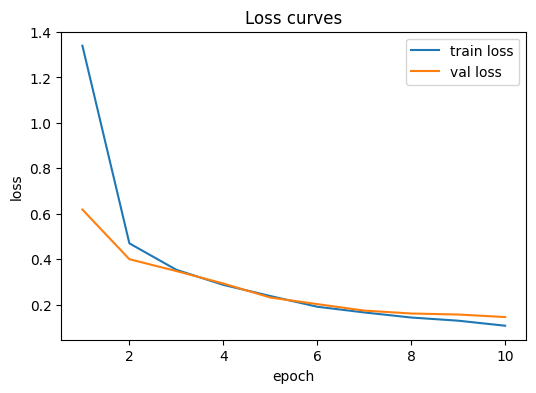

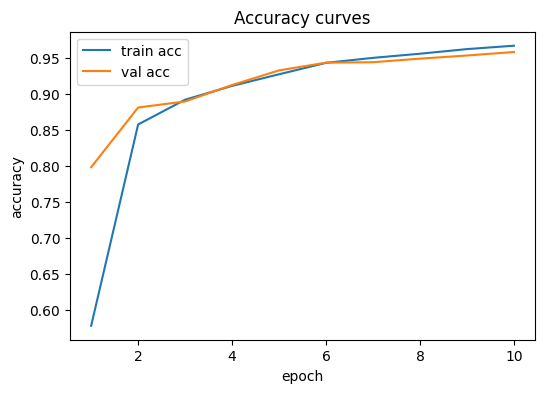

In [ ]:
plot_history(history)

**What we see:**
- Training loss decreases rapidly in the first few epochs.

- Validation loss also decreases steadily and closely follows training loss.

- Both curves flatten smoothly after ~epoch 6–7.

**What this means:**
- The model is learning effectively

  - The sharp drop in loss early on indicates the model is quickly learning useful features (edges, strokes, shapes).

- Good generalization
  - Training and validation losses stay very close.
  - There is no divergence where validation loss increases while training loss decreases.

- Well-chosen hyperparameters
  - The learning rate is not too high (no instability or oscillation).
  - The learning rate is not too low (training progresses efficiently).
  - Weight decay is helping regularize without hurting learning.

**Key takeaway:**

When both training and validation loss decrease together and stabilize, it indicates stable learning and good generalization.

# Exercise 2 - Image Segmentation

Image segmentation is a computer vision technique that partitions a digital image into distinct, meaningful regions or segments at the pixel level.


<table align="center">
    <tr>
        <td align="center">
            <img src="https://raw.githubusercontent.com/mateuszbuda/brain-segmentation-pytorch/refs/heads/master/assets/TCGA_DU_6404_19850629.gif"
                 alt="TCGA_DU_6404_19850629" width="250">
        </td>
        <td align="center">
            <img src="https://raw.githubusercontent.com/mateuszbuda/brain-segmentation-pytorch/refs/heads/master/assets/TCGA_HT_7879_19981009.gif"
                 alt="TCGA_HT_7879_19981009" width="250">
        </td>
        <td align="center">
            <img src="https://raw.githubusercontent.com/mateuszbuda/brain-segmentation-pytorch/refs/heads/master/assets/TCGA_CS_4944_20010208.gif"
                 alt="TCGA_CS_4944_20010208" width="250">
        </td>
    </tr>
    <tr>
        <td align="center"><b>94% DSC</b></td>
        <td align="center"><b>91% DSC</b></td>
        <td align="center"><b>89% DSC</b></td>
    </tr>
</table>

Now we will use **U-Net**, an early model for image segmentation to look at identifying brain tumors in CT scan images.  First we will load the model from torch hub and download an image to test on.

<figure>
<p style="text-align:center;"  align = "center"><img src="https://raw.githubusercontent.com/mateuszbuda/brain-segmentation-pytorch/refs/heads/master/assets/unet.png" alt="Trulli" style="width:100%"  align = "center"></p>
<figcaption align = "center">U-Net Architecture for Brain Segmentation<a href="https://github.com/mateuszbuda/brain-segmentation-pytorch"> Official GitHub Release</a> </figcaption>
</figure>




## 1. Installation and Imports

In [ ]:
! pip install medpy
import urllib.request
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color
from skimage.io import imsave
from medpy.filter.binary import largest_connected_component
from scipy.ndimage import binary_dilation

## 2. Loading the Model and Test Image

**What are Pretrained Models?**

A pretrained model is a neural network whose weights have already been learned by training on a large dataset before we use it in our own code.

In other words:
The model has prior experience.

This means:
- The U-Net architecture is loaded
- The weights were trained beforehand on brain MRI images

- The model already knows:
  - What brain tissue looks like
  - How tumor regions differ from healthy tissue
  - How to draw accurate segmentation boundaries

**Torch Hub**

Torch Hub is a repository of pre-trained deep learning models and an API within the PyTorch library that facilitates research reproducibility and model sharing.

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


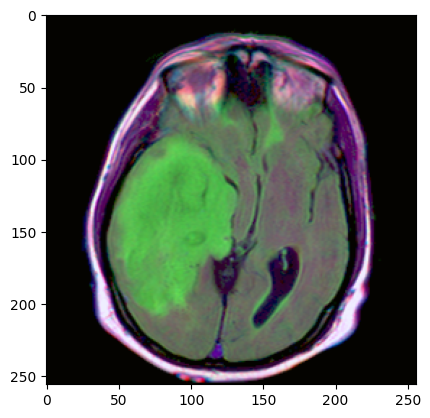

In [ ]:
# Load Model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
model.eval()

# Load Test Image
urllib.request.urlretrieve("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
img = Image.open("TCGA_CS_4944.png").convert("RGB")
plt.imshow(img)
plt.show()

Code to preprocess the image is as follows:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1, 0.1, 0.1], std=[0.5, 0.5, 0.5]),
])

x = transform(img).unsqueeze(0)
with torch.no_grad():
    y = model(x)

## Inferencing the model on the test image

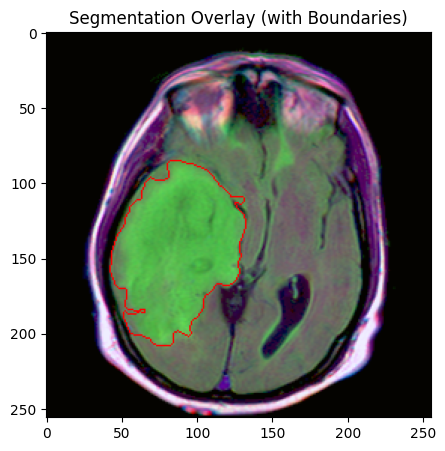

In [ ]:
y_pred_np = y.squeeze().detach().cpu().numpy()
y_pred_np = (y_pred_np > 0.5).astype(np.uint8)  # Thresholding
y_pred_np = largest_connected_component(y_pred_np)  # Keep largest connected component

# Convert image to numpy array
img_np = np.array(img)

# Generate Edge Map using Binary Dilation
def create_boundary(mask):
    edge = binary_dilation(mask) ^ mask  # Create boundary from binary mask
    return edge

# Generate boundary map
boundary_mask = create_boundary(y_pred_np)

# Overlay Boundaries on the Image
img_with_boundary = img_np.copy()
img_with_boundary[boundary_mask == 1] = [255, 0, 0]  # Red outline

# Display results
plt.figure(figsize=(10, 5))
plt.title("Segmentation Overlay (with Boundaries)")
plt.imshow(img_with_boundary)

We can see that the boundaries of the tumour has been located pretty accurately.

# Exercise 3 - Diffusion Models (DDPM) Tutorial
This notebook gives you hands-on code for a *minimal* diffusion model (DDPM).

We are now talking about models generating data, previously int he case of segmentaiton or image classification, we already had the data, we wanted to better locate it or categorize it. But now, Diffusion models are Generative AI, which means they are known for generating ie: creating data.

Naturally, then the question arises: We live in a world with an abundance of data, then,

**Why do we need to generate data?**

- Having a lot of data doesnt necessarily mean that it is relevant data. Most real-world data are imbalances, biased or incomplete. So the problem is not the quantity of the data but the quality.

- Diffusion Models gives us a way to simulate plausible data wihout new data collection.

Generative Models are not just about creating new data, it is about **understanding** the structure of the data.

For example, when asked to draw a picture of a smiley face, you are able to draw it as you understand that the structure of a smiley face is :)

Similarily, when a model is said to be able to generate data, it means that, it is able to first understand the structure of the data and is then able to replicate it.

**What are Diffusion Models?**

- Diffusion Models are a family of probabilistic generative AI models that create new data - such as images, audio, video or 3D structures -  by learning how to reverse a gradual, step-by-step noise addition process.

- **Overarching Idea:** Diffusion Models work by learning how to remove noise.

Diffusion Models have a 2-stage process:

- **Forward Process:**
  - In the forward process, we gradually add small amounts of Gaussian Noise to an image:
  
    x₀ → x₁ → x₂ → ... → x_T

    such that, at the end of the process, the image contains no information - just noise. Therefore, no learning happens here.

- **Reverse Process:**
  - In the reverse process, we train a neural network to answer:

  > **Given a noisy image and a timestep, what noise was added?**

  - Therefore, here, the model learns the how to remove the noise at every noise level, and y doing so, it implicitly learns the structure of the image distribution.

The specific Diffusion Model we are building today is called a **Denoising Diffusion Probabilistic Model (DDPM)**.

DDPM was introduced in 2020 and is the foundation of many SOTA Diffusion Models such as:
- Stable Diffusion
- Imagen
- DALLE-style diffusion pipelines

Today we are coding the simplified version of the same idea used in the SOTA image generators!

## 1. Imports + Setup

We are importing and installing the relevant packages needed.

We also set the seed number to be 123 for reproducability purposes.

In [ ]:
import os, math, random, time
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 2. Configuration

We build a data class - which is just a clean way to store configuration values - to define all the hyperparamters for our experiment in one place.

In [ ]:
@dataclass
class CFG:
    img_size: int = 32
    batch_size: int = 128
    num_workers: int = 2
    lr: float = 2e-4
    epochs: int = 150
    train_subset: int = 20000  # reduce for speed (set None for full)
    img_channels: int = 3

    # Diffusion steps
    T: int = 200  # fewer steps = faster demo; typical papers use 1000
    beta_start: float = 1e-4
    beta_end: float = 0.02

cfg = CFG()
cfg


CFG(img_size=32, batch_size=128, num_workers=2, lr=0.0002, epochs=150, train_subset=20000, img_channels=3, T=200, beta_start=0.0001, beta_end=0.02)

- **Image Size:** Colorized-MNIST
images are 32x32 in spatial resolution.

- **Image Channels:** Tells the model that we are working with RGB images as the number of channels = 3.

- **Batch Size:** Numbe rof images we process in parallel.

- **Num Workers:** Number of CPU workers to load the data in parallel - this affects speed and not learning.

- **Learning Rate**


## 3. Loading the Dataset - Colourized MNIST

We prepare the trainnig data so our diffusion model receives images in the exact format it expects - RGB, 32x32, and scaled to [-1,1].

In [ ]:
import os
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# ---- Paths (your existing path) ----
DATA_DIR = r"/content/colorized_mnist/colorized-MNIST-master"
TRAIN_DIR = os.path.join(DATA_DIR, "training")
TEST_DIR  = os.path.join(DATA_DIR, "testing")

# ---- Image settings ----
# Diffusion models want values in [-1, 1]
mean = (0.5, 0.5, 0.5)
std  = (0.5, 0.5, 0.5)

# Keep transforms same for fairness (your existing rule)
train_tfms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# ---- Dataset ----
full_train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
test_ds       = datasets.ImageFolder(TEST_DIR,  transform=test_tfms)

# Optional: class names (fine to keep)
class_names = full_train_ds.classes
print("Classes:", class_names)

# ---- Subset (from dump code) ----
if cfg.train_subset is not None:
    idx = np.random.permutation(len(full_train_ds))[:cfg.train_subset]
    train_ds = Subset(full_train_ds, idx.tolist())
else:
    train_ds = full_train_ds

# ---- DataLoader (from dump code) ----
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=(device.type == "cuda"),
    drop_last=True,  # recommended for diffusion
)

print("Train size:", len(train_ds))


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Train size: 8835


### Visualize a batch

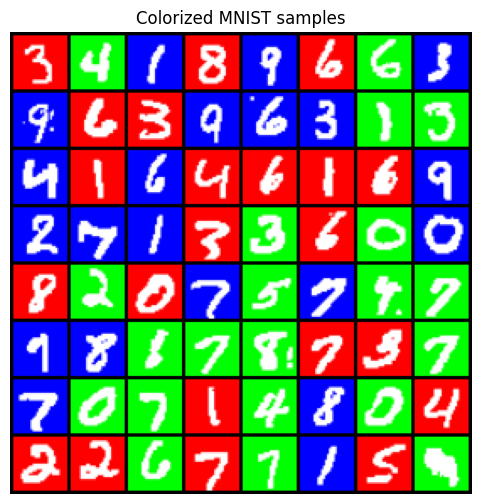

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_images(x, title="", n=64):
    """
    x: Tensor [B,C,H,W] in [-1,1]
    """
    x = (x.clamp(-1, 1) + 1) / 2  # -> [0,1]

    grid = make_grid(x[:n], nrow=int(n**0.5))

    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(title)
    plt.show()

xb, _ = next(iter(train_loader))
show_images(xb, "Colorized MNIST samples")

## 3. Forward Diffusion
We define a noise schedule βₜ and compute:

- αₜ = 1 − βₜ
- \bar{α}ₜ = Πₛ≤ₜ αₛ

Sampling noisy image:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t}\,\epsilon,\quad \epsilon\sim\mathcal{N}(0,I)$$



In [ ]:
# Create beta schedule
betas = torch.linspace(cfg.beta_start, cfg.beta_end, cfg.T, device=device)  # [T]
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)  # [T]

def q_sample(x0, t, noise=None):
    """Sample x_t given x_0 at timestep t (0-indexed)."""
    if noise is None:
        noise = torch.randn_like(x0)
    # Gather alpha_bar_t for each element in batch
    a_bar = alphas_bar[t].view(-1, 1, 1, 1)  # [B,1,1,1]
    return torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * noise, noise


### See what forward diffusion does

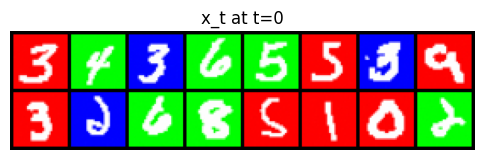

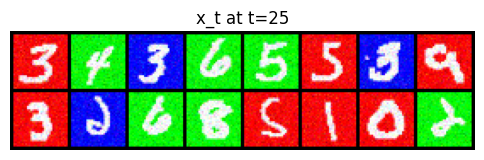

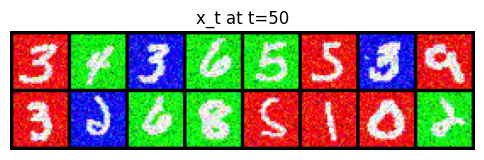

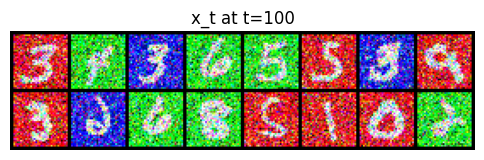

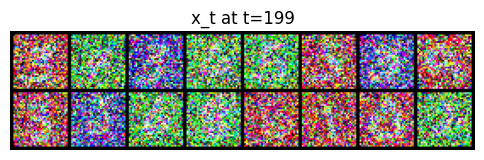

In [ ]:
x0, _ = next(iter(train_loader))
x0 = x0.to(device)[:16]

ts = torch.tensor([0, 25, 50, 100, 199], device=device)
outs = []
for t in ts:
    xt, _ = q_sample(x0, torch.full((x0.size(0),), t, device=device, dtype=torch.long))
    outs.append(xt)

for i, t in enumerate(ts.tolist()):
    show_images(outs[i], title=f"x_t at t={t}")


In the forward diffusion process, we progressively add Gaussian noise to an image so that it transitions smoothly from structured data to pure noise in a mathematically controlled way, as shown above.

## 4) Noise-Predictor Network ε_θ(xₜ, t)
We train a network to predict the noise that was added.

Loss:
$$\mathcal{L}=\mathbb{E}_{t, x_0, \epsilon}[\|\epsilon-\epsilon_\theta(x_t,t)\|^2]$$

For MNIST we can use a tiny U-Net-like CNN with a timestep embedding.

In [ ]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        # t: [B] integer timesteps
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device) / (half - 1))
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
        return emb  # [B, dim]

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(t_dim, out_ch)
        self.act = nn.SiLU()
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.act(self.bn1(self.conv1(x)))
        # Add time embedding (broadcast over H,W)
        t = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t
        h = self.act(self.bn2(self.conv2(h)))
        return h + self.res(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, t_dim=64, base=64):
        super().__init__()
        self.t_embed = SinusoidalTimeEmbedding(t_dim)
        self.t_mlp = nn.Sequential(
            nn.Linear(t_dim, t_dim*4),
            nn.SiLU(),
            nn.Linear(t_dim*4, t_dim)
        )

        # ↓↓↓ change: 1 -> in_ch
        self.down1 = ResBlock(in_ch, base, t_dim)
        self.down2 = ResBlock(base, base*2, t_dim)
        self.pool  = nn.MaxPool2d(2)

        self.mid   = ResBlock(base*2, base*2, t_dim)

        self.up    = nn.Upsample(scale_factor=2, mode="nearest")
        self.up1   = ResBlock(base*2 + base, base, t_dim)

        # ↓↓↓ change: 1 -> out_ch
        self.out   = nn.Conv2d(base, out_ch, 1)

    def forward(self, x, t):
        t_emb = self.t_mlp(self.t_embed(t))

        h1 = self.down1(x, t_emb)              # [B, base, H, W]
        h2 = self.down2(self.pool(h1), t_emb)  # [B, 2base, H/2, W/2]
        h  = self.mid(h2, t_emb)

        h  = self.up(h)                        # [B, 2base, H, W]
        h  = torch.cat([h, h1], dim=1)         # skip
        h  = self.up1(h, t_emb)
        return self.out(h)                     # predict noise epsilon

eps_model = TinyUNet(in_ch=3, out_ch=3, t_dim=64, base=64).to(device)
optimizer = torch.optim.Adam(eps_model.parameters(), lr=cfg.lr)

sum(p.numel() for p in eps_model.parameters())/1e6


0.783619

## 5) Training loop

In [ ]:
def train_one_epoch():
    eps_model.train()
    loss_meter = 0.0

    for x0, _ in train_loader:
        x0 = x0.to(device)
        B = x0.size(0)

        t = torch.randint(0, cfg.T, (B,), device=device, dtype=torch.long)
        xt, noise = q_sample(x0, t)
        noise_pred = eps_model(xt, t)

        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        loss_meter += loss.item()

    return loss_meter / len(train_loader)

losses = []
for epoch in range(1, cfg.epochs+1):
    t0 = time.time()
    loss = train_one_epoch()
    losses.append(loss)
    print(f"Epoch {epoch:02d} | loss {loss:.4f} | {(time.time()-t0):.1f}s")


Epoch 01 | loss 0.3598 | 5.3s
Epoch 02 | loss 0.1364 | 4.7s
Epoch 03 | loss 0.1104 | 5.3s
Epoch 04 | loss 0.0990 | 4.7s
Epoch 05 | loss 0.0903 | 4.9s
Epoch 06 | loss 0.0842 | 5.3s
Epoch 07 | loss 0.0827 | 4.7s
Epoch 08 | loss 0.0783 | 5.3s
Epoch 09 | loss 0.0737 | 4.8s
Epoch 10 | loss 0.0720 | 4.8s
Epoch 11 | loss 0.0685 | 5.9s
Epoch 12 | loss 0.0665 | 5.7s
Epoch 13 | loss 0.0673 | 6.0s
Epoch 14 | loss 0.0641 | 5.1s
Epoch 15 | loss 0.0618 | 5.1s
Epoch 16 | loss 0.0627 | 5.6s
Epoch 17 | loss 0.0613 | 5.2s
Epoch 18 | loss 0.0589 | 6.0s
Epoch 19 | loss 0.0582 | 4.8s
Epoch 20 | loss 0.0587 | 6.0s
Epoch 21 | loss 0.0554 | 4.9s
Epoch 22 | loss 0.0567 | 5.2s
Epoch 23 | loss 0.0573 | 5.6s
Epoch 24 | loss 0.0553 | 5.0s
Epoch 25 | loss 0.0521 | 5.7s
Epoch 26 | loss 0.0530 | 4.8s
Epoch 27 | loss 0.0549 | 5.3s
Epoch 28 | loss 0.0513 | 5.0s
Epoch 29 | loss 0.0534 | 4.8s
Epoch 30 | loss 0.0525 | 5.9s
Epoch 31 | loss 0.0503 | 4.8s
Epoch 32 | loss 0.0506 | 5.2s
Epoch 33 | loss 0.0510 | 5.4s
Epoch 34 |

### Plot loss

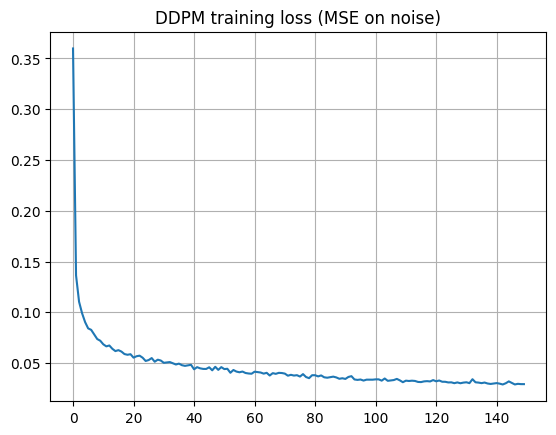

In [ ]:
plt.figure()
plt.plot(losses)
plt.title("DDPM training loss (MSE on noise)")
plt.grid(True)
plt.show()


## 6) Sampling (Reverse Diffusion)
We start from pure noise **x_T ~ N(0,I)** and step backwards:
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\,\epsilon_\theta(x_t,t)\right) + \sigma_t z$$
with $z\sim N(0,I)$ for stochasticity.

This is the classic DDPM ancestral sampler.

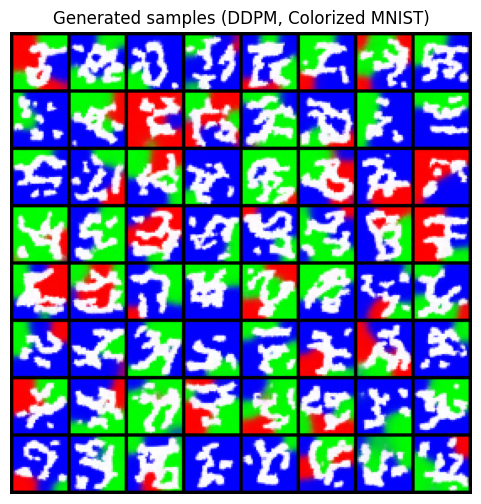

In [ ]:

# ---------------------------
# Visualizer (RGB-safe)
# ---------------------------
def show_images(x, title="", n=64):
    """
    x: [B,C,H,W] in [-1,1]
    """
    x = (x.clamp(-1, 1) + 1) / 2  # -> [0,1]
    grid = make_grid(x[:n], nrow=int(n**0.5))
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(title)
    plt.show()

# ---------------------------
# Reverse step: p(x_{t-1} | x_t)
# ---------------------------
@torch.no_grad()
def p_sample(x, t):
    """
    Sample x_{t-1} from x_t using the DDPM update.

    x: [B,C,H,W] in roughly [-1,1]
    t: integer scalar in [0, T-1]
    """
    B = x.size(0)
    t_batch = torch.full((B,), t, device=x.device, dtype=torch.long)

    # Predict noise eps_theta(x_t, t)
    eps = eps_model(x, t_batch)  # [B,C,H,W]

    # Make scalars broadcastable to [B,C,H,W]
    beta_t      = betas[t].view(1, 1, 1, 1)
    alpha_t     = alphas[t].view(1, 1, 1, 1)
    alpha_bar_t = alphas_bar[t].view(1, 1, 1, 1)

    # DDPM mean (mu_theta)
    mean = (1.0 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * eps)

    if t == 0:
        return mean  # final sample

    # Simple variance choice: sigma_t^2 = beta_t
    z = torch.randn_like(x)
    return mean + torch.sqrt(beta_t) * z

# ---------------------------
# Full sampling loop
# ---------------------------
@torch.no_grad()
def sample(n=64):
    eps_model.eval()

    # IMPORTANT: RGB + 32x32
    x = torch.randn(n, cfg.img_channels, cfg.img_size, cfg.img_size, device=device)

    for t in reversed(range(cfg.T)):
        x = p_sample(x, t)

    return x

# ---------------------------
# Generate + visualize
# ---------------------------
samples = sample(64)
show_images(samples, title="Generated samples (DDPM, Colorized MNIST)")

### ✅ Student Task: Reflection
1. What does DDPM predict during training?
  - DDPM learns to predict the noise ϵ that was added to the image at timestep t.

2. Why do we denoise over many steps?
  - Because generating an image in one step is too hard.
  
  - Many small denoising steps break the problem into easier subproblems and allow gradual refinement from coarse structure → fine details.


## Hyperparameter Sensitivity Plots

### Why decreasing T looks noisier

compare forward noise at the same fraction of diffusion

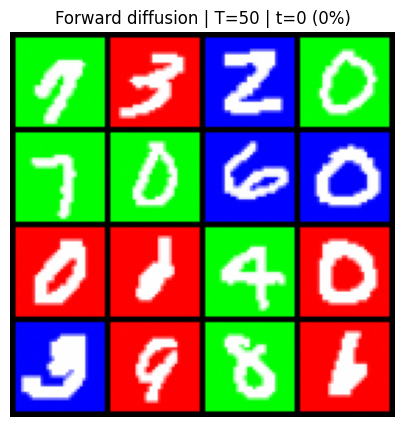

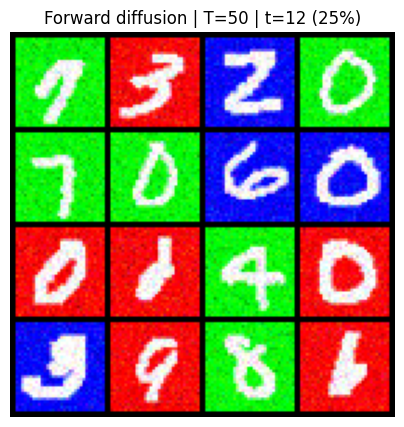

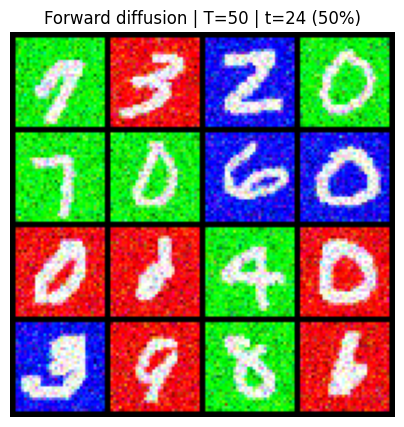

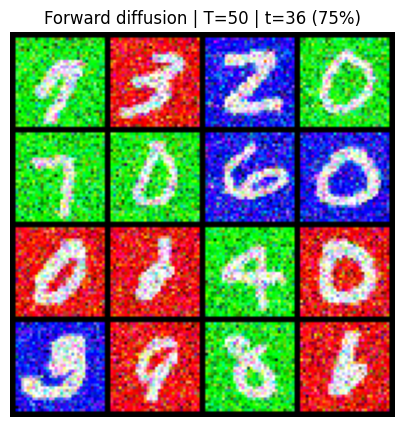

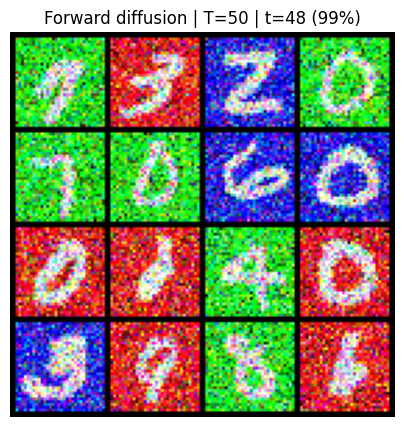

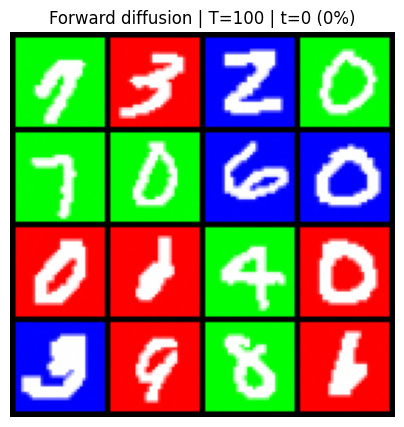

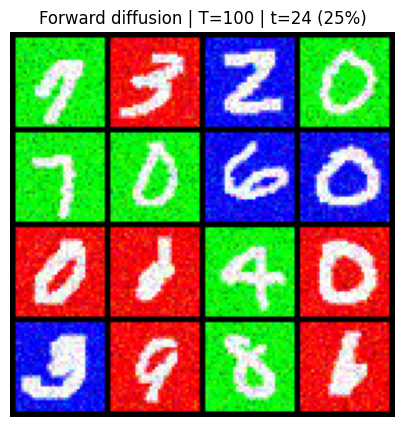

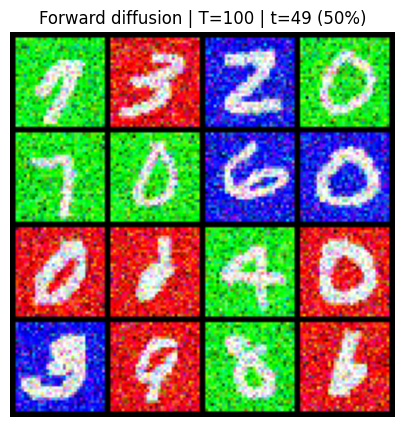

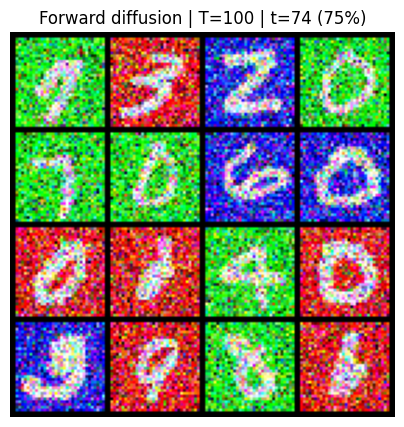

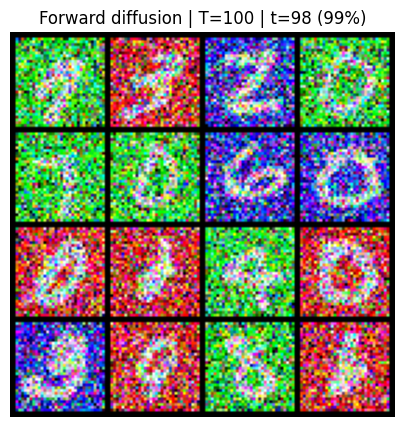

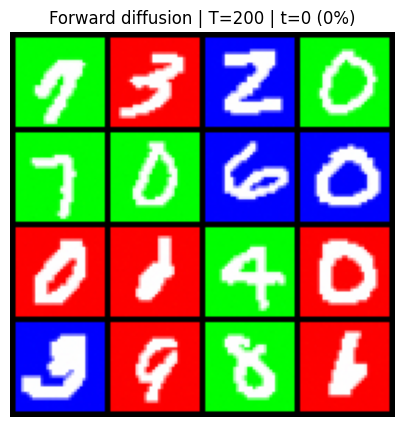

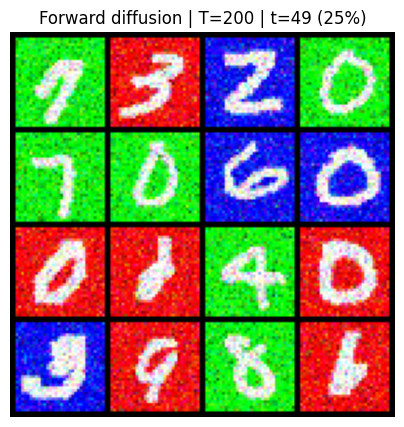

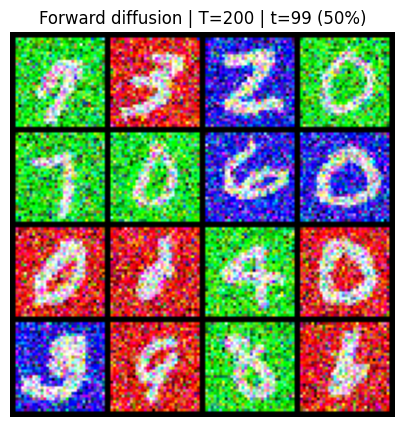

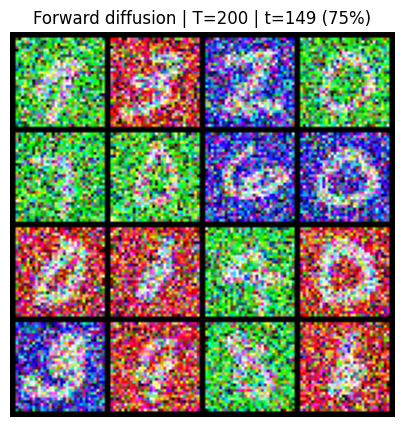

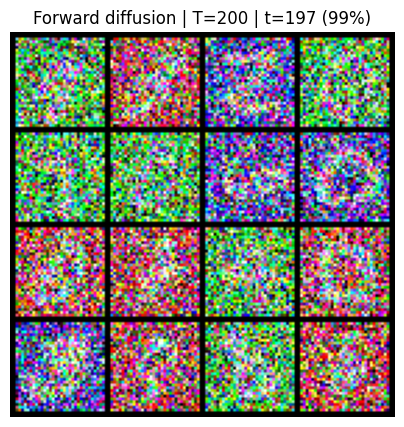

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def build_schedules(T, beta_start, beta_end, device):
    betas = torch.linspace(beta_start, beta_end, T, device=device)
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)
    return betas, alphas, alphas_bar

@torch.no_grad()
def q_sample_with_schedule(x0, t, alphas_bar):
    eps = torch.randn_like(x0)
    a_bar = alphas_bar[t].view(-1,1,1,1)
    xt = torch.sqrt(a_bar) * x0 + torch.sqrt(1.0 - a_bar) * eps
    return xt

def show_grid(x, title="", n=16):
    x = (x.clamp(-1,1) + 1)/2
    grid = make_grid(x[:n], nrow=4)
    plt.figure(figsize=(5,5))
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.axis("off")
    plt.title(title)
    plt.show()

# pick one batch
x0, _ = next(iter(train_loader))
x0 = x0.to(device)

# compare different T at same FRACTIONS
Ts = [50, 100, 200]
fractions = [0.0, 0.25, 0.5, 0.75, 0.99]

for T_ in Ts:
    betas_, alphas_, alphas_bar_ = build_schedules(T_, cfg.beta_start, cfg.beta_end, device)
    for f in fractions:
        t = int(f * (T_-1))
        t_batch = torch.full((x0.size(0),), t, device=device, dtype=torch.long)
        xt = q_sample_with_schedule(x0, t_batch, alphas_bar_)
        show_grid(xt, title=f"Forward diffusion | T={T_} | t={t} ({int(f*100)}%)")


## More gradient steps = better samples” (without waiting forever)

Diffusion models learn gradually:
first background/color stats, then blobs, then strokes, then sharp digits.

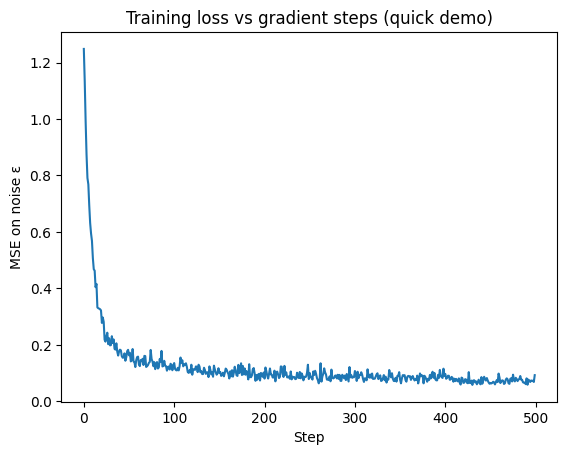

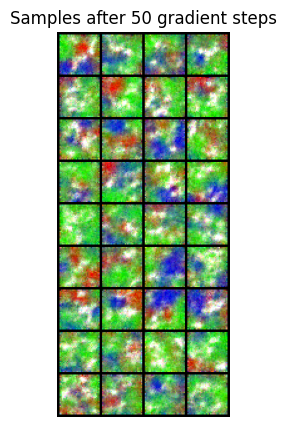

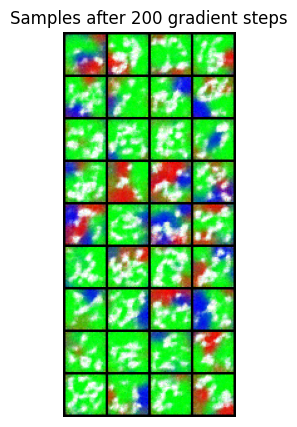

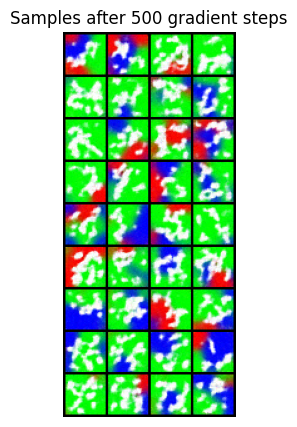

In [ ]:
import numpy as np
import torch.nn.functional as F

def train_steps_with_snapshots(eps_model, optimizer, train_loader, snap_steps=(50, 200, 500), max_steps=500):
    eps_model.train()
    losses = []
    snaps = {}

    it = iter(train_loader)
    for step in range(1, max_steps+1):
        try:
            x0, _ = next(it)
        except StopIteration:
            it = iter(train_loader)
            x0, _ = next(it)

        x0 = x0.to(device)
        B = x0.size(0)
        t = torch.randint(0, cfg.T, (B,), device=device, dtype=torch.long)

        eps = torch.randn_like(x0)
        x_t, eps = q_sample(x0, t, eps)         # your existing q_sample
        eps_hat = eps_model(x_t, t)
        loss = F.mse_loss(eps_hat, eps)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(eps_model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.item())

        if step in snap_steps:
            eps_model.eval()
            s = sample(36)                      # your patched RGB sample()
            snaps[step] = s.detach().cpu()
            eps_model.train()

    return losses, snaps

# Run a quick demo (fast)
eps_model = TinyUNet(in_ch=cfg.img_channels, out_ch=cfg.img_channels, t_dim=64, base=64).to(device)
optimizer = torch.optim.Adam(eps_model.parameters(), lr=2e-4)

losses, snaps = train_steps_with_snapshots(eps_model, optimizer, train_loader,
                                           snap_steps=(50, 200, 500), max_steps=500)

# Loss curve
plt.figure()
plt.plot(losses)
plt.title("Training loss vs gradient steps (quick demo)")
plt.xlabel("Step")
plt.ylabel("MSE on noise ε")
plt.show()

# Sample snapshots
for k in sorted(snaps.keys()):
    show_grid(snaps[k], title=f"Samples after {k} gradient steps", n=36)
